In [2]:
import gymnasium as gym
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

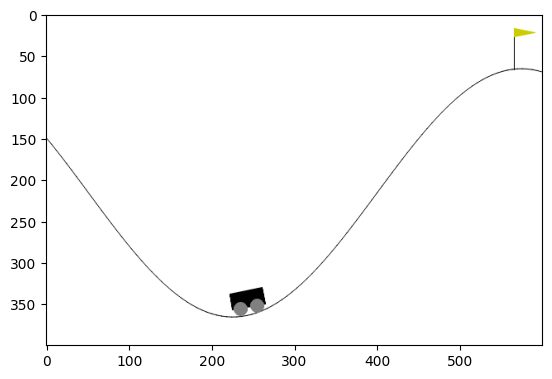

In [3]:
# Create the environment
env = gym.make('MountainCar-v0', render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [4]:
# Action Space in MountainCar environment
print("Action Space: ", env.action_space)

Action Space:  Discrete(3)


In [5]:
# 1= push left, 2= no push, 3= push right

In [6]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [7]:
# Since in this  environment, position and velocity are continuous. To simplify, I need to split it categories like bins
# For better managing, I am gonna use 40 bins for velocity and 60 bins for position, I think this is enough to cover the whole range
# More bins need more time
position_bins_value = 60
velocity_bins_value = 40

# Define the range of position and velocity
position_min = env.observation_space.low[0]
position_max = env.observation_space.high[0]
velocity_min = env.observation_space.low[1] 
velocity_max = env.observation_space.high[1]


 
# Create the bins for position and velocity
position_bins = np.linspace(position_min, position_max, position_bins_value)
velocity_bins = np.linspace(velocity_min, velocity_max, velocity_bins_value)

In [8]:
# Define the Q table
Q_table = np.zeros((position_bins_value, velocity_bins_value, env.action_space.n))
Q_table.shape

(60, 40, 3)

**Q_table has 2400 states and 3 actions**

In [9]:
# I got this helper function from Lecture note 
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    Q[state[0], state[1], action] = Q[state[0], state[1], action] + alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1]]) - Q[state[0], state[1], action])
    return Q

In [10]:
def get_state(observation):
    position = np.digitize(observation[0], bins=position_bins) - 1
    velocity = np.digitize(observation[1], bins=velocity_bins) - 1
    return position, velocity

In [11]:
total_episodes = 15000
max_steps = 200
learning_rate = 0.2
gamma = 0.99
epsilon = 0.9
max_epsilon = 0.9
min_epsilon = 0.0
decay_rate = 0.003

### Training loop

In [12]:
rewards = []
for episode in range(total_episodes):
    state, info = env.reset()
    state = get_state(state)
    done = False
    total_rewards = 0
    
    
    for step in range(max_steps):

        # exploration and exploitation
        if np.random.uniform(0, 1) > epsilon:
            action = np.argmax(Q_table[state[0], state[1]])
        else:
            action = env.action_space.sample()
            
        new_state, reward, done, truncated, info = env.step(action)
        position = new_state[0]
        new_state = get_state(new_state)

        if done and position >= 0.5:
            reward = 150
            Q_table = calculate_value(Q_table, state, action, reward, new_state, learning_rate, gamma)
            total_rewards += reward
            print(f'Episode {episode} done, steps needed {step}, rewards: {total_rewards}, epsilon: {epsilon:.3f}')
            break

        Q_table = calculate_value(Q_table, state, action, reward, new_state, learning_rate, gamma)
        state = new_state
        total_rewards = total_rewards + reward

    rewards.append(total_rewards)
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)      

Episode 1732 done, steps needed 176, rewards: -26.0, epsilon: 0.005
Episode 1752 done, steps needed 197, rewards: -47.0, epsilon: 0.005
Episode 1856 done, steps needed 168, rewards: -18.0, epsilon: 0.003
Episode 1859 done, steps needed 161, rewards: -11.0, epsilon: 0.003
Episode 1877 done, steps needed 193, rewards: -43.0, epsilon: 0.003
Episode 1887 done, steps needed 174, rewards: -24.0, epsilon: 0.003
Episode 1899 done, steps needed 170, rewards: -20.0, epsilon: 0.003
Episode 1920 done, steps needed 162, rewards: -12.0, epsilon: 0.003
Episode 1945 done, steps needed 172, rewards: -22.0, epsilon: 0.003
Episode 1965 done, steps needed 193, rewards: -43.0, epsilon: 0.002
Episode 1966 done, steps needed 173, rewards: -23.0, epsilon: 0.002
Episode 2024 done, steps needed 190, rewards: -40.0, epsilon: 0.002
Episode 2047 done, steps needed 197, rewards: -47.0, epsilon: 0.002
Episode 2059 done, steps needed 199, rewards: -49.0, epsilon: 0.002
Episode 2068 done, steps needed 198, rewards: -4

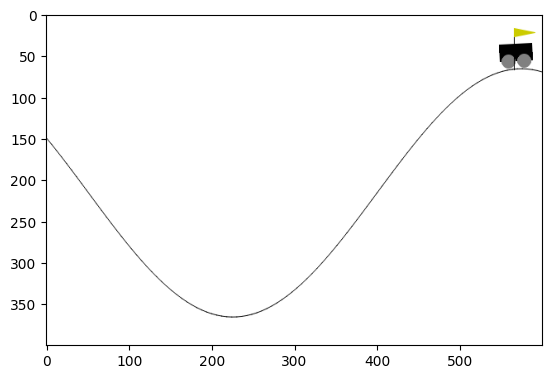

Episode: 2 done with total_rewards: -115.0


In [13]:
total_test_episodes = 2

env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

for episode in range(total_test_episodes):
    state, info = env.reset()
    state = get_state(state)
    done = False
    total_rewards = 0


    for step in range(max_steps):
        
        
        action = np.argmax(Q_table[state[0], state[1]])
        observation, reward, done, truncated, info = env.step(action)
        observation = get_state(observation)
        total_rewards = total_rewards + reward

        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()
        if done:
            print(f"Episode: {episode + 1} done with total_rewards: {total_rewards}")
            time.sleep(2)
            break
        state = observation
env.close()